In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

# **LOAD HATE DATASET**

In [5]:
df = pd.read_csv('hate.csv',encoding = "ISO-8859-1", engine= "python")
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N
...,...,...
41139,Indian culture is so backwards,N
41140,"Women don't want equality, they just want to b...",N
41141,fuck covid,P
41142,This computer is garbage,P


**DATA PRE-PROCESSING**
---
Data preprocessing is a crucial step in machine learning to ensure the data is clean, consistent, and ready for model training. It includes operations like handling missing values, removing duplicates, encoding categorical variables, and feature extraction to make the dataset suitable for machine learning algorithms.



In [8]:
df.drop_duplicates(subset=['comment', 'label'], keep='first', inplace=True)
df

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N
...,...,...
41139,Indian culture is so backwards,N
41140,"Women don't want equality, they just want to b...",N
41141,fuck covid,P
41142,This computer is garbage,P


In [10]:
df = df[df['label'] != 'O']
df

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N
...,...,...
41139,Indian culture is so backwards,N
41140,"Women don't want equality, they just want to b...",N
41141,fuck covid,P
41142,This computer is garbage,P


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df['comment'])
y = df['label'].apply(lambda x: 1 if x == 'P' else 0)
y

0        0
1        0
2        0
3        0
4        0
        ..
41139    0
41140    0
41141    1
41142    1
41143    0
Name: label, Length: 41098, dtype: int64

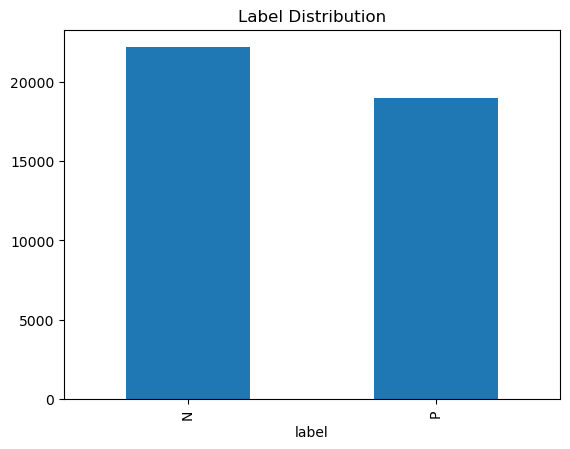

In [13]:
df['label'].value_counts().plot(kind='bar', title='Label Distribution')
plt.show()

**Exploratory Data Analysis (EDA)**
---
Exploratory Data Analysis (EDA) involves visualizing feature distributions (using histograms or KDE plots) and analyzing the target variable's balance with bar charts or histograms. Correlation heatmaps reveal relationships between features, while techniques like SMOTE address class imbalance for better model performance.


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24 () missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: 
lesbians are really gro$$
                       ^
ParseException: Expected end of text, found '$'  (at char 23), (line:1, col:24)

<Figure size 800x600 with 1 Axes>

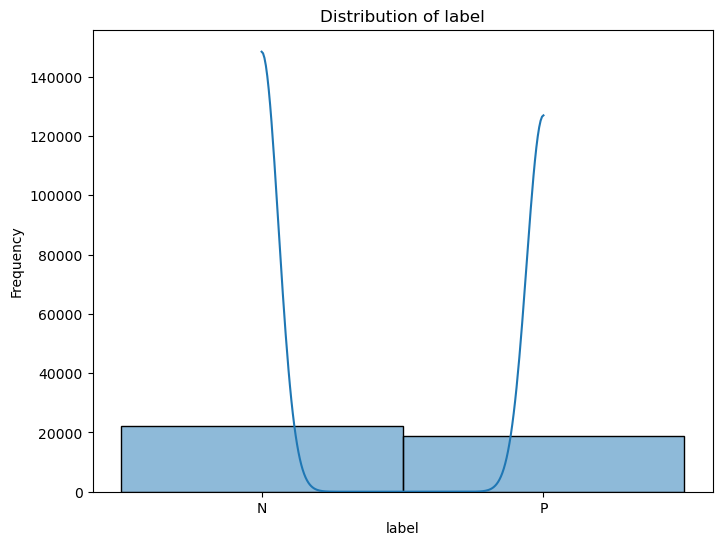

In [15]:
for col in df.columns:
    try:
        plt.figure(figsize=(8, 6))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()
    except ValueError as e:
        print(f"Error plotting distribution for column '{col}': {e}")

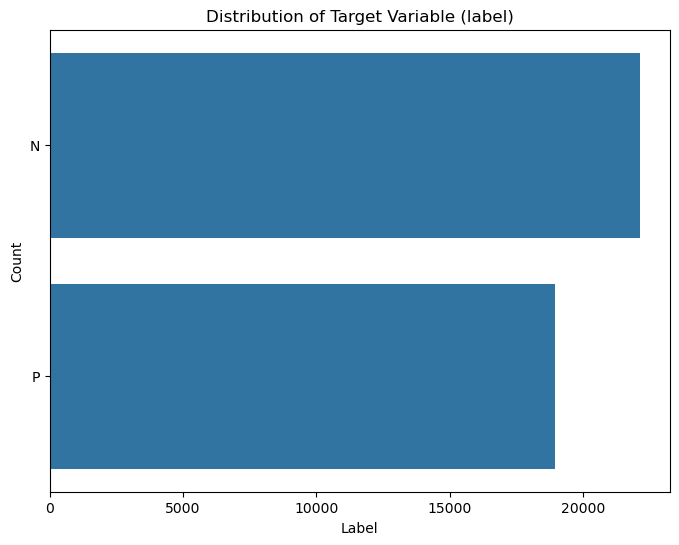

In [16]:
# Plot the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(df['label'])
plt.title("Distribution of Target Variable (label)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder

# Assume 'df' is the original DataFrame
df_encoded = df.copy()

# Encode text columns as numeric
label_encoder = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df_encoded[col] = label_encoder.fit_transform(df[col])



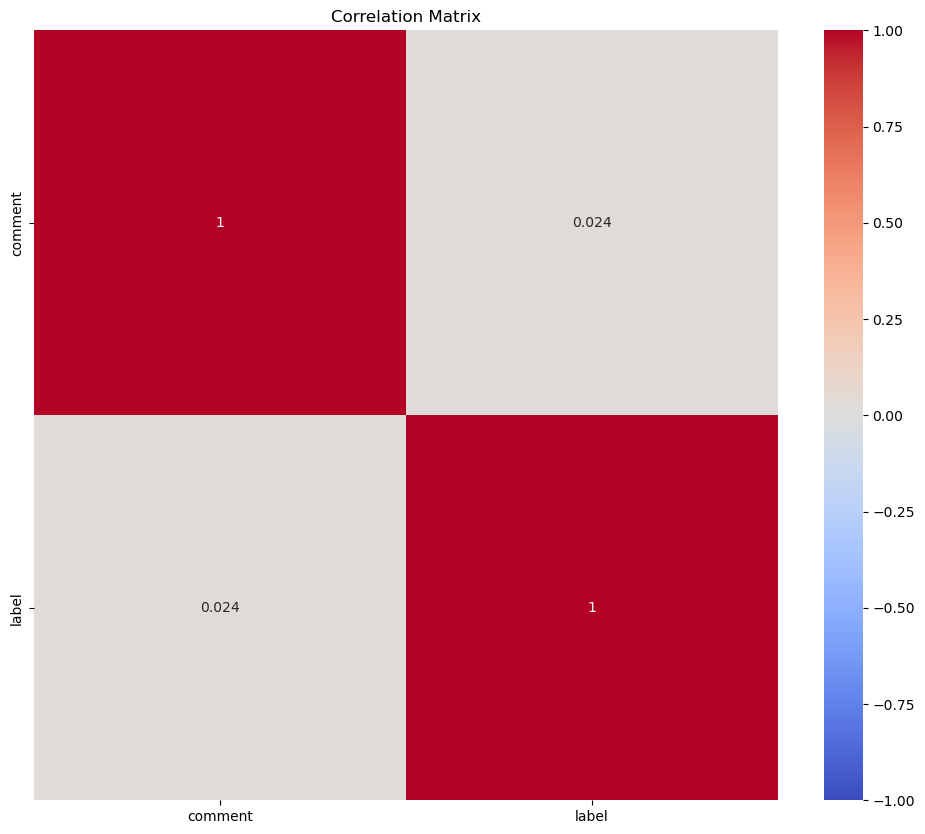

In [19]:
# Calculate the correlation matrix
corr_matrix = df_encoded.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

In [21]:
# Calculate the correlation between features and target
target_correlations = df_encoded.corr()['label'].sort_values(ascending=False)

# Print the results
print("Correlation of Features with Target Variable:")
print(target_correlations)

Correlation of Features with Target Variable:
label      1.000000
comment    0.024236
Name: label, dtype: float64


**To address class imbalance by randomly undersampling the majority class. This balances the dataset but reduces the size of the majority class.**

In [23]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)


**Apply TrainTestSplit and GridSearchCV as well as cross-validation**

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
import shap
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42)

In [26]:
# cross-validation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)

# Scale the features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# **RandomForestClassifier**

In [39]:
# RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)

# Make predictions
y_pred_random = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_random)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.55


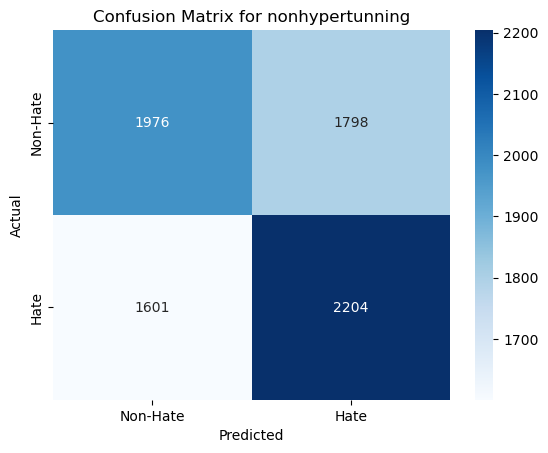

In [41]:
# confusion matrix for without GridSearchCV

cm_rand = confusion_matrix(y_test, y_pred_random)
sns.heatmap(cm_rand, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for nonhypertunning')
plt.show()

In [42]:
# f1-score
f1 = f1_score(y_test, y_pred_random,average=None)
print(f"F1-score: {f1}")

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_random)
print(f"AUC-ROC: {auc_roc:.2f}")

#classification report
report = classification_report(y_test, y_pred_random)
print(report)

F1-score: [0.53761393 0.56462149]
AUC-ROC: 0.55
              precision    recall  f1-score   support

           0       0.55      0.52      0.54      3774
           1       0.55      0.58      0.56      3805

    accuracy                           0.55      7579
   macro avg       0.55      0.55      0.55      7579
weighted avg       0.55      0.55      0.55      7579



In [43]:
#with GridSearchCV
rf_params = {'n_estimators':[100], 'max_depth': [5, 10, 15]}
rf_model = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test,y_pred )

print(f"Random Forest Accuracy: {rf_acc:.2f}")

Random Forest Accuracy: 0.64


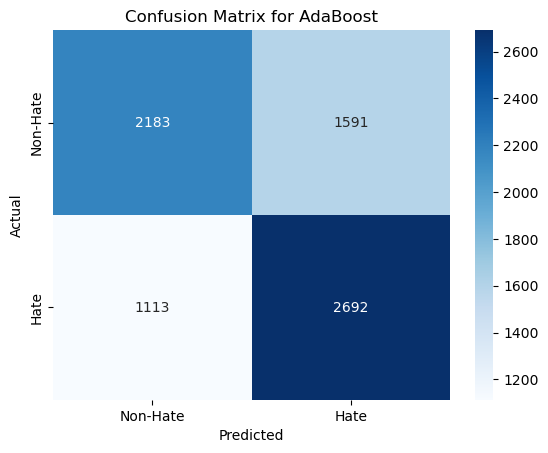

In [44]:
cm_randomboost = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_randomboost, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost')
plt.show()

In [45]:
# f1-score
f1 = f1_score(y_test, y_pred)
print(f"F1-score: {f1:.2f}")

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC: {auc_roc:.2f}")

#classification report
report = classification_report(y_test, y_pred)
print(report)

F1-score: 0.67
AUC-ROC: 0.64
              precision    recall  f1-score   support

           0       0.66      0.58      0.62      3774
           1       0.63      0.71      0.67      3805

    accuracy                           0.64      7579
   macro avg       0.65      0.64      0.64      7579
weighted avg       0.65      0.64      0.64      7579



# **AdaBoostClassifier**

In [72]:
# AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Train the model
ab_params = {'n_estimators': [500], 'algorithm': ['SAMME'] }
ada_model = GridSearchCV(AdaBoostClassifier(algorithm='SAMME'), ab_params, cv=5)
ada_model.fit(X_train, y_train)

# Make predictions
y_pred_adaboost = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_adaboost)
print(f"Accuracy of AdaBoost: {accuracy:.2f}")

# ab_params = {'n_estimators': [100]}
# ada_model = AdaBoostClassifier(n_estimators=100)
# ada_model.fit(X_train, y_train)

# # Make predictions
# y_pred_adaboost = model.predict(X_test)

# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred_adaboost)
# print(f"Accuracy of AdaBoost: {accuracy:.2f}")


Accuracy of AdaBoost: 0.55


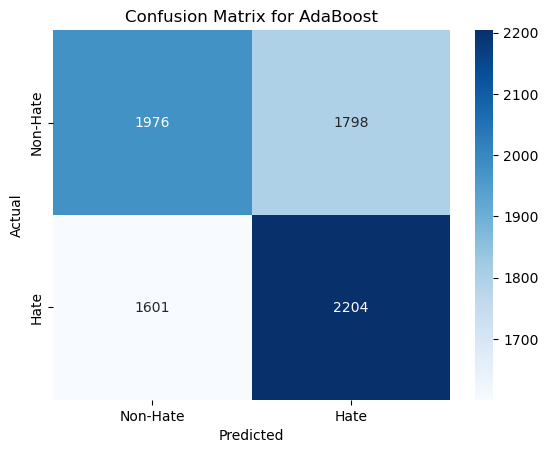

In [48]:
cm_addboost = confusion_matrix(y_test, y_pred_adaboost)
sns.heatmap(cm_addboost, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost')
plt.show()

In [49]:
# f1-score
f1 = f1_score(y_test, y_pred_adaboost)
print(f"F1-score: {f1:.2f}")

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_adaboost)
print(f"AUC-ROC: {auc_roc:.2f}")

#classification report
report = classification_report(y_test, y_pred_adaboost)
print(report)

F1-score: 0.56
AUC-ROC: 0.55
              precision    recall  f1-score   support

           0       0.55      0.52      0.54      3774
           1       0.55      0.58      0.56      3805

    accuracy                           0.55      7579
   macro avg       0.55      0.55      0.55      7579
weighted avg       0.55      0.55      0.55      7579



# **GradientBoostingClassifier**

In [51]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
gb_params = {'n_estimators': [150], 'learning_rate': [0.1, 0.01, 0.001]}
gradient_boosting_model = GridSearchCV(GradientBoostingClassifier(), gb_params, cv=5)
model.fit(X_train, y_train)

# Make predictions
y_pred_gradient = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_gradient)
print(f"Accuracy of Gradient Boosting Classifier : {accuracy:.2f}")


Accuracy of Gradient Boosting Classifier : 0.55


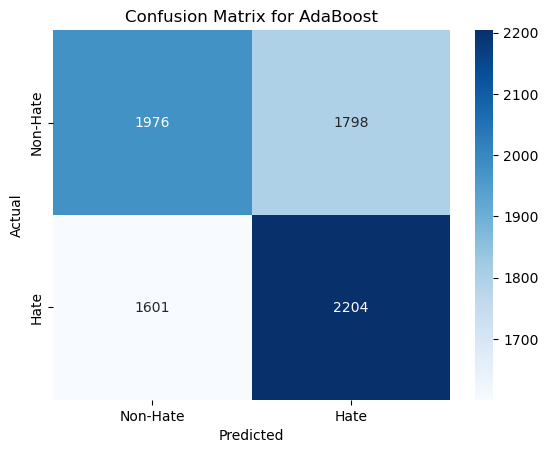

In [52]:
cm_gredientboost = confusion_matrix(y_test, y_pred_gradient)
sns.heatmap(cm_gredientboost, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for AdaBoost')
plt.show()

In [1]:
# f1-score
f1 = f1_score(y_test, y_pred_gradient)
print(f"F1-score: {f1:.2f}")

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_gradient)
print(f"AUC-ROC: {auc_roc:.2f}")

#classification report
report = classification_report(y_test, y_pred_gradient)
print(report)

NameError: name 'f1_score' is not defined

# **Neural Network : MLPClassifier**

In [ ]:
from sklearn.neural_network import MLPClassifier

# mlp_param = {'hidden_layer_sizes': [(50,)], 'max_iter':[100], 'activation':['relu'], 'solver':['adam'], 'alpha':[0.0001]}

mlp_param = {
    'hidden_layer_sizes': [(50,50), (100,)],  # Try different layer configurations
    'max_iter': [300], 
    'activation': ['relu', 'tanh'], 
    'solver': ['adam', 'sgd'], 
    'alpha': [0.0001, 0.001,0.01],  # Adjust regularization strength
    'learning_rate': ['constant', 'adaptive']
}

nural_mlp_model = GridSearchCV(MLPClassifier(), mlp_param, cv=5)
nural_mlp_model.fit(X_train, y_train)

y_pred_mlp = nural_mlp_model.predict(X_test)
nural_mlp_model_acc = accuracy_score(y_test, y_pred_mlp)

print(f"Neural Network Accuracy: {nural_mlp_model_acc:.2f}")

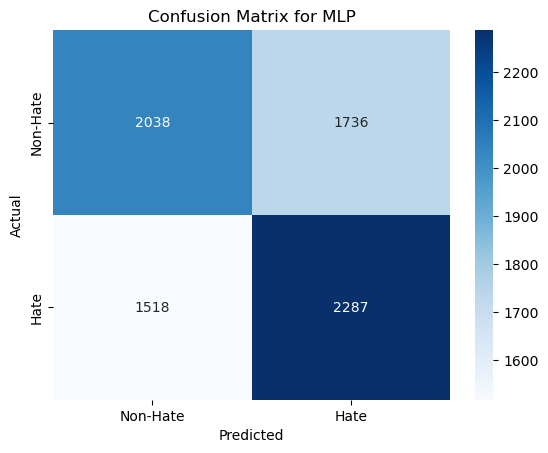

In [56]:
# Confusion Matrix for AdaBoost
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP')
plt.show()

In [57]:
# f1-score
f1 = f1_score(y_test, y_pred_mlp)
print(f"F1-score: {f1:.2f}")

# AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_mlp)
print(f"AUC-ROC: {auc_roc:.2f}")

#classification report
report = classification_report(y_test, y_pred_mlp)
print(report)

F1-score: 0.58
AUC-ROC: 0.57
              precision    recall  f1-score   support

           0       0.57      0.54      0.56      3774
           1       0.57      0.60      0.58      3805

    accuracy                           0.57      7579
   macro avg       0.57      0.57      0.57      7579
weighted avg       0.57      0.57      0.57      7579

